# Homework 6 - Generative Adversarial Network
This is the sample code for hw6 of 2022 Machine Learning course in National Taiwan University. 

In this sample code, there are 5 sections:
1. Environment setting
2. Dataset preparation
3. Model setting
4. Train
5. Inference

Your goal is to do anime face generation, if you have any question, please discuss at NTU COOL 

# Environment setting
In this section, we will prepare for the dataset and set some environment variable

## Download Dataset

In [ ]:
# get dataset from huggingface hub
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | bash
!apt-get install git-lfs
!git lfs install
!git clone https://huggingface.co/datasets/LeoFeng/MLHW_6
!unzip ./MLHW_6/faces.zip -d .

In [ ]:
# Install StyleGAN2
!pip install stylegan2_pytorch

## Other setting

In [1]:
# import module
import os
import glob
import random
import math
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import logging
from tqdm import tqdm

# from stylegan2_pytorch import ModelLoader

# seed setting
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(2022)
workspace_dir = '.'

# Dataset preparation
In this section, we prepare for the dataset for Pytorch

## Create dataset for Pytorch

In order to unified image information, we use the transform function to:
1. Resize image to 64x64
2. Normalize the image

This CrypkoDataset class will be use in Section 4

In [2]:
# prepare for CrypkoDataset

class CrypkoDataset(Dataset):
    def __init__(self, fnames, transform):
        self.transform = transform
        self.fnames = fnames
        self.num_samples = len(self.fnames)

    def __getitem__(self,idx):
        fname = self.fnames[idx]
        img = torchvision.io.read_image(fname)
        img = self.transform(img)
        return img

    def __len__(self):
        return self.num_samples

def get_dataset(root):
    fnames = glob.glob(os.path.join(root, '*'))
    compose = [
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]
    transform = transforms.Compose(compose)
    dataset = CrypkoDataset(fnames, transform)
    return dataset

## Show the image
Show some sample in the dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


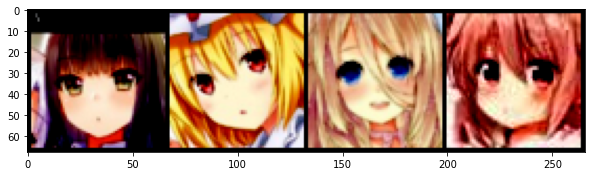

In [3]:
temp_dataset = get_dataset(os.path.join(workspace_dir, 'faces'))

images = [temp_dataset[i] for i in range(4)]
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

# Model setting
In this section, we will create models and trainer.

## Create model
In this section, we will create models for Generator and Discriminator

In [4]:
# Generator
class Generator(nn.Module):
    """
    Input shape: (batch, in_dim)
    Output shape: (batch, 3, 64, 64)
    """
    def __init__(self, in_dim, feature_dim=64):
        super().__init__()
    
        #input: (batch, 100)
        self.l1 = nn.Sequential(
            nn.Linear(in_dim, feature_dim * 8 * 4 * 4, bias=False),
            nn.BatchNorm1d(feature_dim * 8 * 4 * 4),
            nn.ReLU()
        )
        self.l2 = nn.Sequential(
            self.dconv_bn_relu(feature_dim * 8, feature_dim * 4),               #(batch, feature_dim * 16, 8, 8)     
            self.dconv_bn_relu(feature_dim * 4, feature_dim * 2),               #(batch, feature_dim * 16, 16, 16)     
            self.dconv_bn_relu(feature_dim * 2, feature_dim),                   #(batch, feature_dim * 16, 32, 32)     
        )
        self.l3 = nn.Sequential(
            nn.ConvTranspose2d(feature_dim, 3, kernel_size=5, stride=2,
                               padding=2, output_padding=1, bias=False),
            nn.Tanh()   
        )
        self.apply(weights_init)
    def dconv_bn_relu(self, in_dim, out_dim):
        return nn.Sequential(
            nn.ConvTranspose2d(in_dim, out_dim, kernel_size=5, stride=2,
                               padding=2, output_padding=1, bias=False),        #double height and width
            nn.BatchNorm2d(out_dim),
            nn.ReLU(True)
        )
    def forward(self, x):
        y = self.l1(x)
        y = y.view(y.size(0), -1, 4, 4)
        y = self.l2(y)
        y = self.l3(y)
        return y

In [5]:
# Discriminator
class Discriminator(nn.Module):
    """
    Input shape: (batch, 3, 64, 64)
    Output shape: (batch)
    """
    def __init__(self, in_dim, model_type, feature_dim=64):
        super(Discriminator, self).__init__()
            
        #input: (batch, 3, 64, 64)
        """
        NOTE FOR SETTING DISCRIMINATOR:

        Remove last sigmoid layer for WGAN
        """
        self.model_type = model_type
        modules = [
            nn.Conv2d(in_dim, feature_dim, kernel_size=4, stride=2, padding=1), #(batch, 3, 32, 32)
            nn.LeakyReLU(0.2),
            self.conv_bn_lrelu(feature_dim, feature_dim * 2),                   #(batch, 3, 16, 16)
            self.conv_bn_lrelu(feature_dim * 2, feature_dim * 4),               #(batch, 3, 8, 8)
            self.conv_bn_lrelu(feature_dim * 4, feature_dim * 8),               #(batch, 3, 4, 4)
            nn.Conv2d(feature_dim * 8, 1, kernel_size=4, stride=1, padding=0)
        ]
        if self.model_type == 'GAN':
            modules.append(nn.Sigmoid())
        self.l1 = nn.Sequential(*modules)
        
        self.apply(weights_init)
    def conv_bn_lrelu(self, in_dim, out_dim):
        """
        NOTE FOR SETTING DISCRIMINATOR:

        You can't use nn.Batchnorm for WGAN-GP
        # Use nn.InstanceNorm2d instead
        """

        norm = nn.InstanceNorm2d(out_dim) if self.model_type == 'WGAN-GP' else nn.BatchNorm2d(out_dim)

        return nn.Sequential(
            nn.Conv2d(in_dim, out_dim, 4, 2, 1),
            norm,
            nn.LeakyReLU(0.2),
        )
    def forward(self, x):
        y = self.l1(x)
        y = y.view(-1)
        return y

In [6]:
# setting for weight init function
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

## Create trainer
In this section, we will create a trainer which contains following functions:
1. prepare_environment: prepare the overall environment, construct the models, create directory for the log and ckpt
2. train: train for generator and discriminator, you can try to modify the code here to construct WGAN or WGAN-GP
3. inference: after training, you can pass the generator ckpt path into it and the function will save the result for you

In [7]:
class TrainerGAN():
    def __init__(self, config):
        self.config = config
        
        self.G = Generator(100)
        self.D = Discriminator(3, config['model_type'])
        
        self.loss = nn.BCELoss()

        """
        NOTE FOR SETTING OPTIMIZER:

        GAN: use Adam optimizer
        WGAN: use RMSprop optimizer
        WGAN-GP: use Adam optimizer 
        """
        if config['model_type'] == 'GAN' or config['model_type'] == 'WGAN-GP':
            self.opt_D = torch.optim.Adam(self.D.parameters(), lr=self.config["lr"], betas=(0.5, 0.999))
            self.opt_G = torch.optim.Adam(self.G.parameters(), lr=self.config["lr"], betas=(0.5, 0.999))
        elif config['model_type'] == 'WGAN':
            self.opt_D = torch.optim.RMSprop(self.D.parameters(), lr=self.config["lr"])
            self.opt_G = torch.optim.RMSprop(self.G.parameters(), lr=self.config["lr"])
        
        self.dataloader = None
        self.log_dir = os.path.join(self.config["workspace_dir"], 'logs')
        self.ckpt_dir = os.path.join(self.config["workspace_dir"], 'checkpoints')
        
        FORMAT = '%(asctime)s - %(levelname)s: %(message)s'
        logging.basicConfig(level=logging.INFO, 
                            format=FORMAT,
                            datefmt='%Y-%m-%d %H:%M')
        
        self.steps = 0
        self.z_samples = Variable(torch.randn(100, self.config["z_dim"])).cuda()
        
    def prepare_environment(self):
        """
        Use this funciton to prepare function
        """
        os.makedirs(self.log_dir, exist_ok=True)
        os.makedirs(self.ckpt_dir, exist_ok=True)
        
        # update dir by time
        time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
        self.log_dir = os.path.join(self.log_dir, time+f'_{self.config["model_type"]}')
        self.ckpt_dir = os.path.join(self.ckpt_dir, time+f'_{self.config["model_type"]}')
        os.makedirs(self.log_dir)
        os.makedirs(self.ckpt_dir)
        
        # create dataset by the above function
        dataset = get_dataset(os.path.join(self.config["workspace_dir"], 'faces'))
        self.dataloader = DataLoader(dataset, batch_size=self.config["batch_size"], shuffle=True, num_workers=2)
        
        # model preparation
        self.G = self.G.cuda()
        self.D = self.D.cuda()
        self.G.train()
        self.D.train()

    def gp(self, real_imgs, fake_imgs):
        """
        Implement gradient penalty function
        """
        # Random weight term for interpolation between real and fake samples
        alpha = torch.Tensor(np.random.random((real_imgs.size(0), 1, 1, 1))).cuda()
        # Get random interpolation between real and fake samples
        interpolates = (alpha * real_imgs + ((1 - alpha) * fake_imgs)).requires_grad_(True).cuda()
        d_interpolates = self.D(interpolates).cuda()
        fake = Variable(torch.Tensor((real_imgs.shape[0])).fill_(1.0), requires_grad=False).cuda()
        # Get gradient w.r.t. interpolates
        gradients = torch.autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=fake,
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]
        gradients = gradients.view(gradients.size(0), -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return gradient_penalty

    def save_model(self, epoch, gradient_norm):
        # Save checkpoints
        save_path = os.path.join(self.ckpt_dir, f'D_{epoch}.pth')
        check = {
            "model": self.D.state_dict(),
            "grad": gradient_norm,
        }
        torch.save(check, save_path)
        return gradient_norm

    def load_model(self, name=None):
        if os.path.exists(name):
            # Load checkpoints
            D_checkpoint = torch.load(name)
            self.D.load_state_dict(D_checkpoint["model"])
            logging.info(f"loaded Discriminator checkpoint {name}: grad={D_checkpoint['grad']}")
            return D_checkpoint['grad']
        else:
            logging.info(f"No checkpoint named {name}")


    def train(self):
        """
        Use this function to train generator and discriminator
        """
        self.prepare_environment()
        
        gradient_norm = {}

        for e, epoch in enumerate(range(self.config["n_epoch"])):
            progress_bar = tqdm(self.dataloader)
            progress_bar.set_description(f"Epoch {e+1}")
            for i, data in enumerate(progress_bar):
                imgs = data.cuda()
                bs = imgs.size(0)

                # *********************
                # *    Train D        *
                # *********************
                z = Variable(torch.randn(bs, self.config["z_dim"])).cuda()
                r_imgs = Variable(imgs).cuda()
                f_imgs = self.G(z)
                r_label = torch.ones((bs)).cuda()
                f_label = torch.zeros((bs)).cuda()


                # Discriminator forwarding
                r_logit = self.D(r_imgs)
                f_logit = self.D(f_imgs)

                """
                NOTE FOR SETTING DISCRIMINATOR LOSS:
                
                GAN: 
                    loss_D = (r_loss + f_loss)/2
                WGAN: 
                    loss_D = -torch.mean(r_logit) + torch.mean(f_logit)
                WGAN-GP: 
                    gradient_penalty = self.gp(r_imgs, f_imgs)
                    loss_D = -torch.mean(r_logit) + torch.mean(f_logit) + gradient_penalty
                """
                # Loss for discriminator
                if self.config['model_type'] == 'GAN':
                    r_loss = self.loss(r_logit, r_label)                                    # GAN(BECLoss)
                    f_loss = self.loss(f_logit, f_label)                                    # GAN(BCELoss)
                    loss_D = (r_loss + f_loss) / 2                                          # GAN
                elif self.config['model_type'] == 'WGAN':
                    loss_D = -torch.mean(r_logit) + torch.mean(f_logit)                     # WGAN
                elif self.config['model_type'] == 'WGAN-GP':
                    gradient_penalty = self.gp(r_imgs.data, f_imgs.data)                    # WGAN-GP
                    loss_D = -torch.mean(r_logit) + torch.mean(f_logit) + gradient_penalty  # WGAN-GP

                # Discriminator backwarding
                self.D.zero_grad()
                loss_D.backward()
                self.opt_D.step()

                # Gradient Norm
                for name, module in self.D.named_modules():
                    if isinstance(module, nn.Conv2d):
                        gradient_norm[name] = (module.weight.grad.norm(2) ** 2 + module.bias.grad.norm(2) ** 2) ** (1. / 2)

                """
                NOTE FOR SETTING WEIGHT CLIP:
                
                WGAN: below code
                """
                if self.config['model_type'] == 'WGAN':
                    for p in self.D.parameters():
                        p.data.clamp_(-self.config["clip_value"], self.config["clip_value"])



                # *********************
                # *    Train G        *
                # *********************
                if self.steps % self.config["n_critic"] == 0:
                    # Generate some fake images.
                    z = Variable(torch.randn(bs, self.config["z_dim"])).cuda()
                    f_imgs = self.G(z)

                    # Generator forwarding
                    f_logit = self.D(f_imgs)


                    """
                    NOTE FOR SETTING LOSS FOR GENERATOR:
                    
                    GAN: loss_G = self.loss(f_logit, r_label)
                    WGAN: loss_G = -torch.mean(self.D(f_imgs))
                    WGAN-GP: loss_G = -torch.mean(self.D(f_imgs))
                    """
                    # Loss for the generator.
                    if self.config['model_type'] == 'GAN':
                        loss_G = self.loss(f_logit, r_label)        # GAN
                    elif self.config['model_type'] == 'WGAN' or self.config['model_type'] == 'WGAN-GP':
                        loss_G = -torch.mean(self.D(f_imgs))        # WGAN / WGAN-GP

                    # Generator backwarding
                    self.G.zero_grad()
                    loss_G.backward()
                    self.opt_G.step()
                    
                if self.steps % 10 == 0:
                    progress_bar.set_postfix(loss_G=loss_G.item(), loss_D=loss_D.item())
                self.steps += 1

            self.G.eval()
            f_imgs_sample = (self.G(self.z_samples).data + 1) / 2.0
            filename = os.path.join(self.log_dir, f'Epoch_{epoch+1:03d}.jpg')
            torchvision.utils.save_image(f_imgs_sample, filename, nrow=10)
            logging.info(f'Save some samples to {filename}.')

            # Show some images during training.
            grid_img = torchvision.utils.make_grid(f_imgs_sample.cpu(), nrow=10)
            plt.figure(figsize=(10,10))
            plt.imshow(grid_img.permute(1, 2, 0))
            plt.show()

            self.G.train()

            # Save the checkpoints.
            if (e+1) % 5 == 0 or e == 0:
                torch.save(self.G.state_dict(), os.path.join(self.ckpt_dir, f'G_{e}.pth'))
                # torch.save(self.D.state_dict(), os.path.join(self.ckpt_dir, f'D_{e}.pth'))
                self.save_model(e, gradient_norm)

        logging.info('Finish training')

    def inference(self, G_path, n_generate=1000, n_output=30, show=False):
        """
        1. G_path is the path for Generator ckpt
        2. You can use this function to generate final answer
        """

        self.G.load_state_dict(torch.load(G_path))
        self.G.cuda()
        self.G.eval()
        z = Variable(torch.randn(n_generate, self.config["z_dim"])).cuda()
        imgs = (self.G(z).data + 1) / 2.0
        
        os.makedirs('output', exist_ok=True)
        for i in range(n_generate):
            torchvision.utils.save_image(imgs[i], f'output/{i+1}.jpg')
        
        if show:
            row, col = n_output//10 + 1, 10
            grid_img = torchvision.utils.make_grid(imgs[:n_output].cpu(), nrow=row)
            plt.figure(figsize=(row, col))
            plt.imshow(grid_img.permute(1, 2, 0))
            plt.show()

# Train
In this section, we will first set the config for trainer, then use it to train generator and discriminator

## Set config

In [8]:
config = {
    "model_type": "StyleGAN2",      # StyleGAN2 / GAN / WGAN / WGAN-GP
    "batch_size": 64,
    "lr": 0.00005,
    "n_epoch": 200,
    "n_critic": 5,                  # Cycle to train the generator
    "z_dim": 100,                   # Dimension of flatten image
    "clip_value": 0.01,
    "workspace_dir": workspace_dir, # define in the environment setting
}

## Common configuration shared between training and inference.

In [9]:
# model's checkpoints will save in {workspace_dir}/{models_dir}/{name}
models_dir = f'{workspace_dir}/models'
name = 'hw06'           # Project Name
log_dir = './logs'      # Sample log directory
image_type = ''         # Regular / EMA / MR
# Output images directory
output_path = f'{workspace_dir}/output-{image_type}' if len(image_type) != 0 else f'{workspace_dir}/output'

## StyleGAN training Configuration

In [10]:
training_config = {
    'data': f'{workspace_dir}/faces',
    'results_dir': f'{workspace_dir}/out',
    'models_dir': models_dir,
    'name': name,
    'aug-prob': 0.25,
    'aug-types': '[translation,cutout,color]',
    'attn-layers': '1',
    'network-capacity': 16,
    'image-size': 64,
    'batch_size': 16,
    'gradient-accumulate-every': 4,
    'num-train-steps': 50000,
    'num_workers': 12
}

## StyleGAN inference Configuration

In [11]:
inference_config = {
    'generate': True,
    'models_dir': models_dir,       # Models directory
    'load-from': 19,                # Number of generator
    'name': name,
    'results_dir': f'{workspace_dir}/result-{image_type}' if len(image_type) != 0 else f'{workspace_dir}/result',
    'trunc-psi': 0.75,
    'num_generate': 1000,           # Generate 1000 images
    'num_image_tiles': 1            # Image grid 1 x 1
}

## Start to train

In [12]:
if config['model_type'] == 'StyleGAN2':
    # Flattening Configuration as command line.
    training_args = " ".join([f"--{k} {v}" for k, v in training_config.items()])
    training_command = f"stylegan2_pytorch {training_args}"
    # Training Start.
    os.system(f"{training_command}")
else:
    trainer = TrainerGAN(config)
    trainer.train()

continuing from previous epoch - 50
loading from version 1.8.8


/usr/lib/python3/dist-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
hw06<./faces>: 100%|██████████| 50000/50000 [00:00<?, ?it/s]


# Inference
In this section, we will use trainer to train model

## Inference through trainer

In [13]:
if config['model_type'] == 'StyleGAN2':
    inference_args = " ".join([f"--{k} {v}" for k, v in inference_config.items()])
    inference_command = f"stylegan2_pytorch {inference_args}"
    # Inference Start.
    os.system(f"{inference_command}")
else:
    # save the 1000 images into ./output folder
    trainer = TrainerGAN(config)
    trainer.inference(f'{workspace_dir}/checkpoints/2022-04-14_09-26-37_WGAN-GP/G_199.pth') # you have to modify the path when running this line

loading from version 1.8.8


100%|██████████| 1000/1000 [00:20<00:00, 49.66it/s]


sample images generated at ./result/hw06/generated-04-14-2022_13-59-54


## Prepare .tar file for submission

[Info] Regular Images


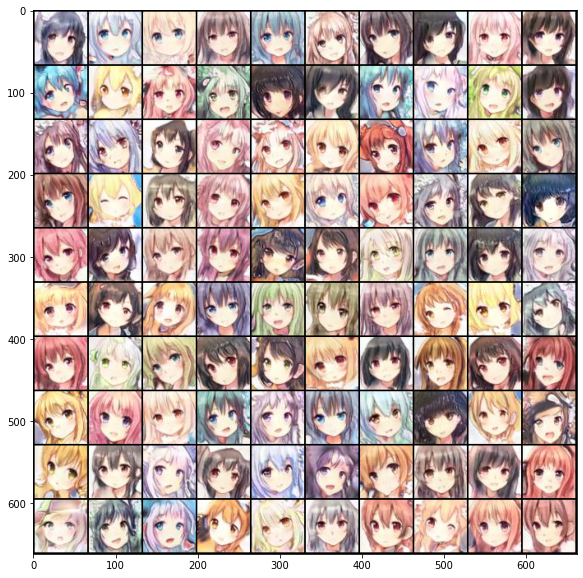

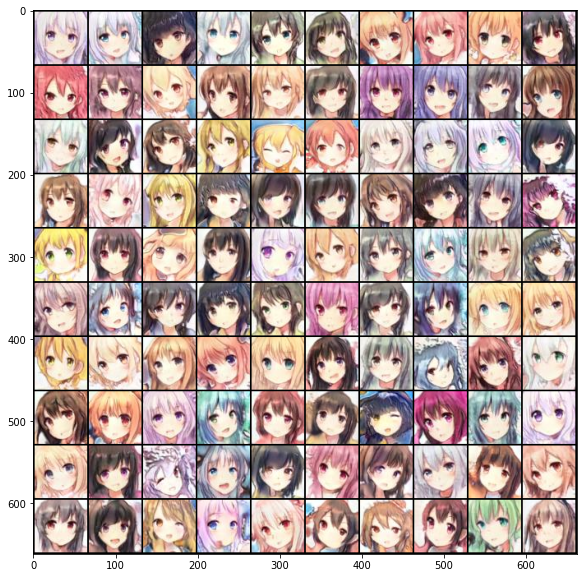

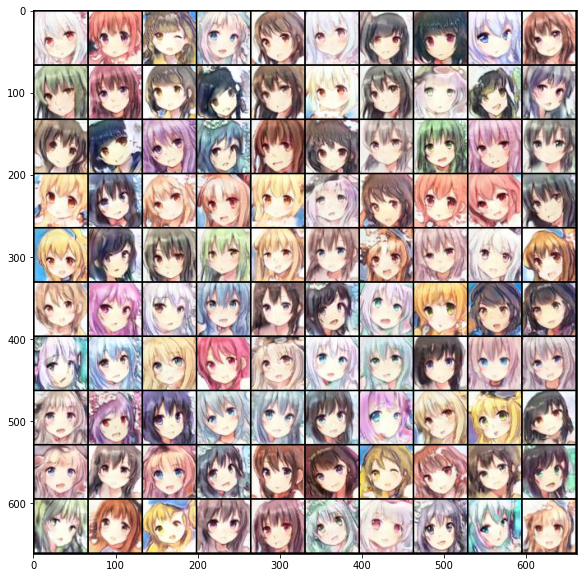

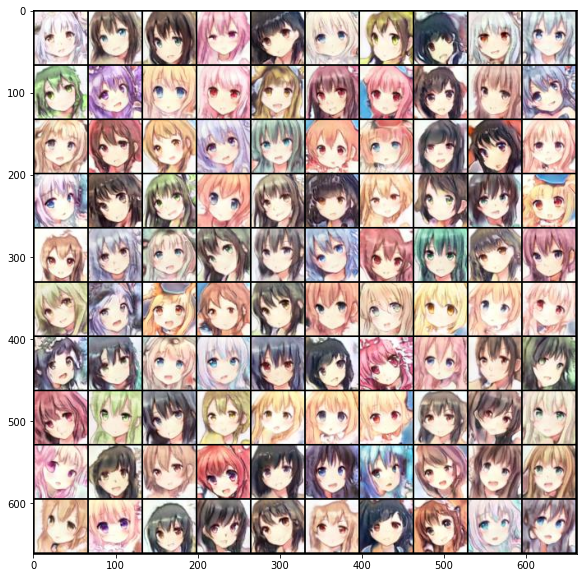

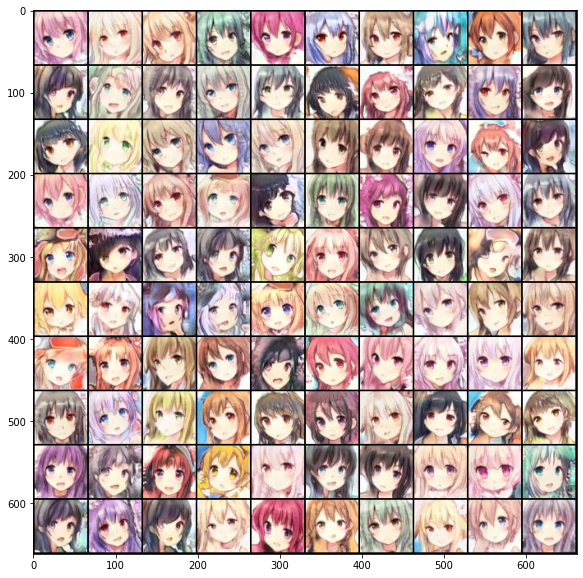

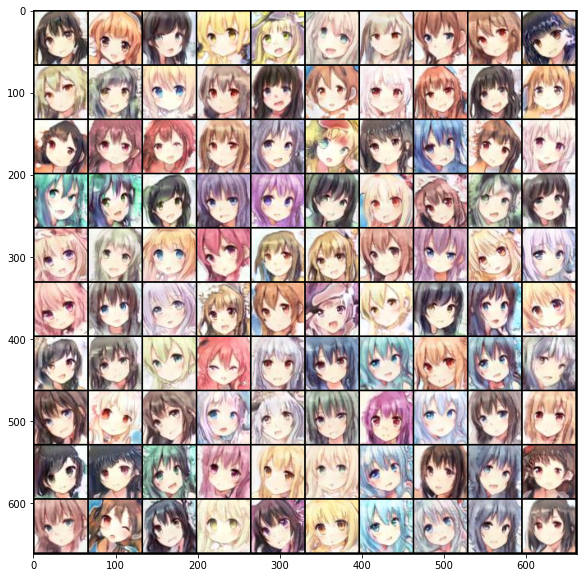

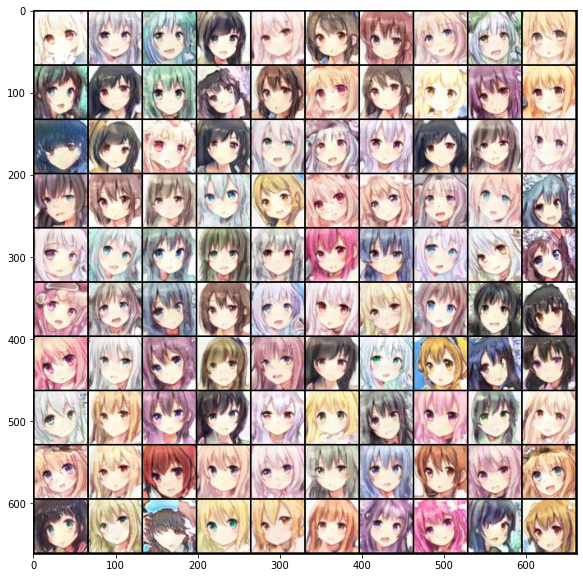

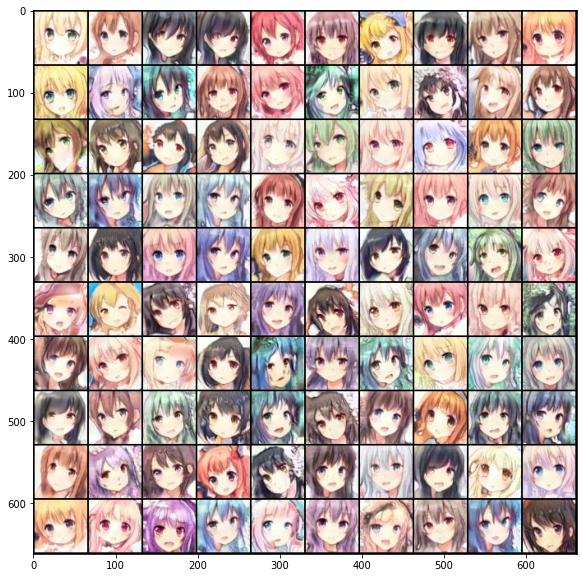

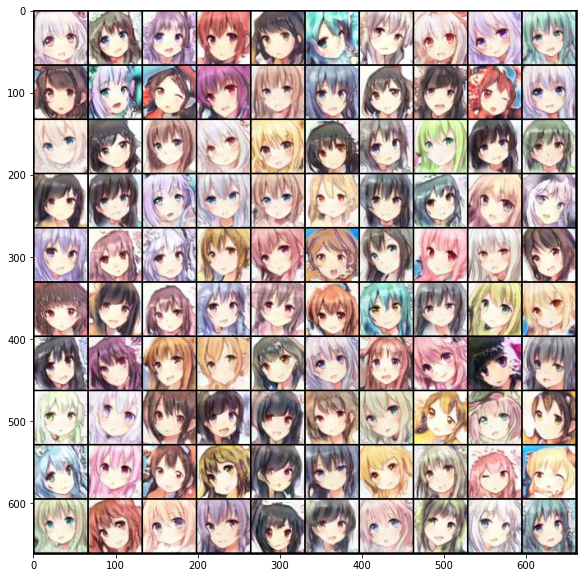

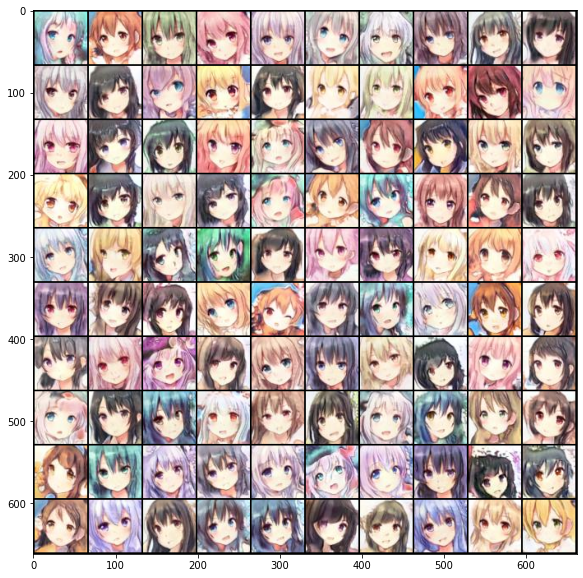

In [14]:
if config['model_type'] == 'StyleGAN2':
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')     # Update dir by time.
    logs_dir = os.path.join(log_dir, time + f'_StyleGAN2-{image_type}') if len(image_type) != 0 else os.path.join(log_dir, time + f'_StyleGAN2')
    if not os.path.exists(logs_dir):
        os.makedirs(logs_dir)
    sample = 100                                            # Sample 100 image each time.

    # PIL image to Tensor.
    transform = transforms.Compose([
        transforms.PILToTensor()
    ])
    # Directory for inference image exists.
    result_path = os.path.join(inference_config['results_dir'], name)
    if os.path.exists(result_path):
        # Extract specific type of images.
        if image_type == 'mr':
            print("[Info] Mixing Regular Images")
            files = sorted([os.path.join(result_path, x) for x in os.listdir(result_path) if x.endswith("mr.jpg")])
        elif image_type == 'ema':
            print("[Info] Moving Average Images")
            files = sorted([os.path.join(result_path, x) for x in os.listdir(result_path) if x.endswith("ema.jpg")])
        elif image_type == '':
            print("[Info] Regular Images")
            files = sorted([os.path.join(result_path, x) for x in os.listdir(result_path) if x.endswith(".jpg") and not x.endswith("ema.jpg") and not x.endswith("mr.jpg")])
        else:
            print("[Info] Unknown type")
            exit(0)

        # Iterative 10 times with each time sampling 100 images to check performance.
        for fold in range(10):
            sample_imgs = [transform(Image.open(files[idx])) for idx in range(fold * sample, (fold+1) * sample)]
            grid_img = torchvision.utils.make_grid(sample_imgs, nrow=10)
            plt.figure(figsize=(10, 10))
            plt.imshow(grid_img.permute(1, 2, 0))
            plt.savefig(os.path.join(logs_dir, f"images_fold-{fold+1}.jpg"))

        # Move the images to the output directory and remane them.
        for index, file in enumerate(files):
            out = os.path.join(output_path, f"{index+1}.jpg")
            os.system(f"cp {file} {out}")
else:
    output_path = 'output'

# Compress the images.
os.chdir(output_path)
os.system("tar -zcf ../submission.tgz *.jpg")
os.chdir("..")

## Plot "Gradient norm"

2022-04-14 14:00 - INFO: loaded Discriminator checkpoint ./checkpoints/2022-04-13_20-20-16_WGAN/D_199.pth: grad={'l1.0': tensor(59.1289, device='cuda:0'), 'l1.2.0': tensor(15.9839, device='cuda:0'), 'l1.3.0': tensor(3.0841, device='cuda:0'), 'l1.4.0': tensor(0.2926, device='cuda:0'), 'l1.5': tensor(0.3639, device='cuda:0')}
2022-04-14 14:00 - INFO: loaded Discriminator checkpoint ./checkpoints/2022-04-14_09-26-37_WGAN-GP/D_199.pth: grad={'l1.0': tensor(334.7995, device='cuda:0'), 'l1.2.0': tensor(132.7563, device='cuda:0'), 'l1.3.0': tensor(119.9750, device='cuda:0'), 'l1.4.0': tensor(107.3905, device='cuda:0'), 'l1.5': tensor(6.7383, device='cuda:0')}


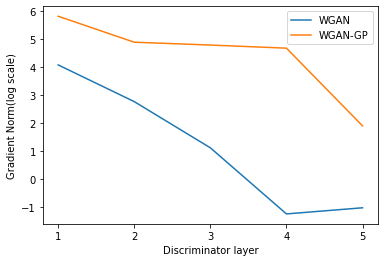

In [15]:
files_path = ['2022-04-13_20-20-16_WGAN/D_199.pth', '2022-04-14_09-26-37_WGAN-GP/D_199.pth']
plt.figure(figsize=(6, 4))
for path in files_path:
    model_type = path.split('/')[0].split('_')[-1]
    config['model_type'] = model_type
    trainer = TrainerGAN(config)
    gradient_norm = trainer.load_model(f'{workspace_dir}/checkpoints/{path}')
    layer_norm = []
    for key, value in gradient_norm.items():
        layer_norm.append(math.log(value))
    plt.plot(list(range(1, len(layer_norm)+1)), layer_norm, label=f'{model_type}')
plt.xlabel('Discriminator layer')
plt.xticks(range(1, len(layer_norm)+1))
plt.ylabel('Gradient Norm(log scale)')
plt.legend()
plt.savefig('report2.jpg', dpi=300)
plt.show()